In [28]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
import emcee

import utils
import model_spectra as NN
import fitting

import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import corner

# Restore Neural Network

In [22]:
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()

# read in all individual neural networks we'll need. 
NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

# Restore Processed Spectra

In [23]:
D_PayneDir = utils.D_PayneDir
SpectraDir = D_PayneDir + 'spectra/obs_spectra/'
SpectraFile = 'm15_Horne.npz'

temp = np.load(SpectraDir + SpectraFile)
obj = temp['obj']
spec = temp['spec']
spectral_err = temp['spec_err']
dv = temp['dv']
RA_Dec = SkyCoord(temp['RA_Dec'])
temp.close()

### Spectra Selection

In [24]:
spec_ind = 8

norm_spec = spec[spec_ind]
spec_err = spectral_err[spec_ind]

### Apply Mask

In [25]:
kirby_2008_stellar = utils.get_spectral_mask_dict(name='kirby_2008_stellar')
mask = utils.generate_mask_from_dict(**kirby_2008_stellar)
spec_err[mask] = 1e16

# Fit with Optimization

In [30]:
p0 = [0, -2, -2, -2, -2, -2, -2, -2, 4100, 0.5, 0]
popt, pcov, model_spec \
    = fitting.fit_normalized_spectrum_single_star_model(norm_spec = norm_spec,
                                                        spec_err = spec_err,
                                                        NN_coeffs = NN_coeffs,
                                                        p0 = p0, num_p0 = 10)
    
def plot1(lambda_bounds):
    # zoom in on a small region of the spectrum so we can see what's going on.
    lambda_min = lambda_bounds[0]
    lambda_max = lambda_bounds[1] 
    m = (wavelength < lambda_max) & (wavelength > lambda_min)
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 4))
    
    ax1.plot(wavelength[m], norm_spec[m], 'k', lw=0.5, label = r'$\mathrm{Data\ Spectra}$')
    ax1.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = r'$\mathrm{Best-Fit\ Model}$')
    ax1.fill(wavelength[m], spec_err[m]/1e16+0.1, "b", alpha=0.2)
    ax1.set_xlim(lambda_min, lambda_max)
    ax1.set_ylim(0.70,1.10)
    ax1.set_ylabel(r'$\mathrm{Normalized\ Flux}$')
    ax1.legend(loc = 'best', frameon = False, fontsize = 12)
    
    ax2.plot(wavelength[m], norm_spec[m]-model_spec[m], 'k', lw=0.5)
    ax2.fill(wavelength[m], spec_err[m]/1e16-0.85, "b", alpha=0.2)
    ax2.hlines(0, lambda_min, lambda_max, linestyles='-')
    ax2.hlines(0.05, lambda_min, lambda_max, linestyles=':', color='b')
    ax2.hlines(-0.05, lambda_min, lambda_max, linestyles=':', color='b')
    ax2.set_ylim(-0.15,0.15)
    ax2.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
    ax2.set_ylabel(r'$\mathrm{Residuals}$')
    
    plt.suptitle('Obj: %s\n\
                 RA: %.5f Dec: %.5f'
                 % (obj[spec_ind], RA_Dec[spec_ind].ra.deg, RA_Dec[spec_ind].dec.deg))
    
    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    plt.show()
interact(plot1, lambda_bounds=widgets.IntRangeSlider(min=6250,max=9500,step=50,value=[8400,8700]))

print('Best Fit Labels:')
print(popt)

interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[-2.23644369e-02 -2.01748803e+00 -1.99538861e+00 -1.96878598e+00
 -2.01717975e+00 -1.95080801e+00 -1.96914522e+00 -1.92772278e+00
  3.99056797e+03  3.28016615e-01 -2.59260637e+00]


# Define Likelihood Function

In [33]:
def lnlike(labels, data_spec, data_err):
    model_spec = NN.get_spectrum_from_neural_net(labels=labels, NN_coeffs=NN_coeffs)
    inv_sigma2 = 1.0/(data_err**2)
    lnchi2 = -0.5 * (np.sum((data_spec - model_spec)**2 * inv_sigma2 - np.log(inv_sigma2)))
    return(lnchi2)


def lnprior(labels):
    abundances = labels[:-3]
    Teff = labels[-3]
    logg = labels[-2]
    dv = labels[-1]
    if np.any(abundances < -5) or np.any(abundances > 1.0):
        return(-np.inf)
    elif (Teff < 3000 or Teff > 10000):
        return(-np.inf)
    elif (logg < 0.3 or logg > 5):
        return(-np.inf)
    elif (dv < -10 or dv > 10):
        return(-np.inf)
    else:
        return(1)


def lnprob(labels, data_spec, data_err):
    lp = lnprior(labels)
    if not np.isfinite(lp):
        return(-np.inf)
    else:
        return(lp + lnlike(labels, data_spec, data_err))

# Run MCMC

In [ ]:
ndim, nwalkers = len(popt), 1000
p0 = [popt + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(norm_spec, spec_err))
pos, prob, state = sampler.run_mcmc(p0,100)

/global/home/users/nathan_sandford/.local/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/global/home/users/nathan_sandford/.local/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
/global/home/users/nathan_sandford/D-Payne/model_spectra.py:21: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


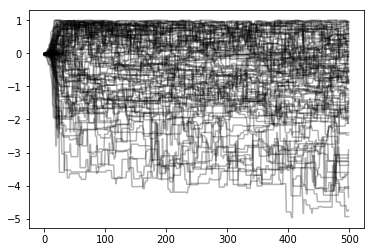

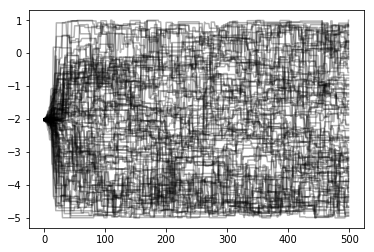

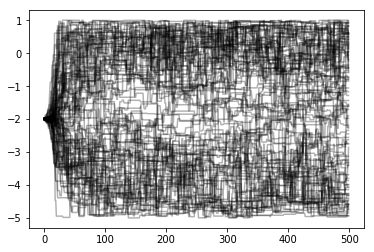

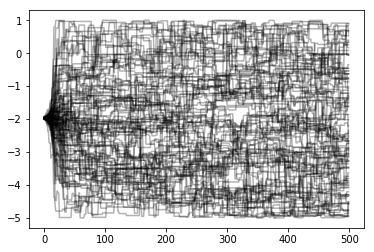

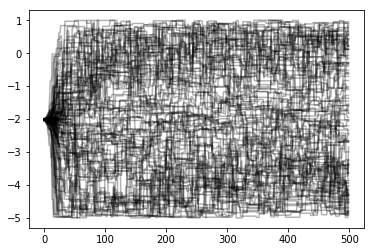

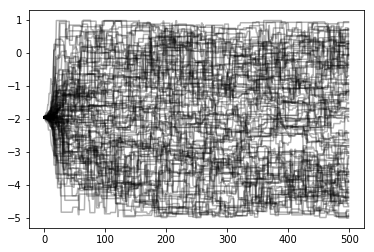

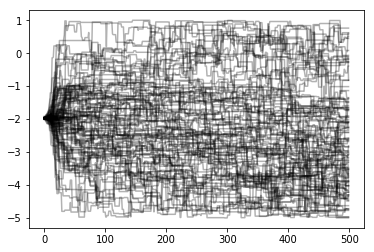

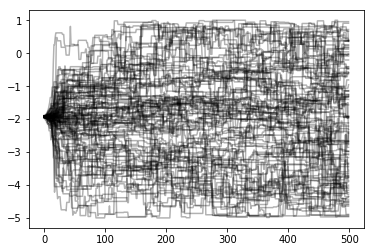

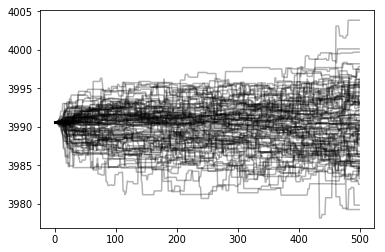

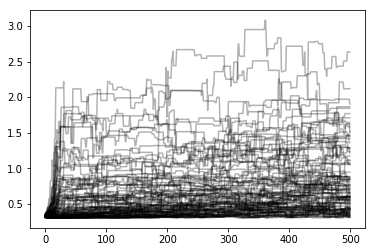

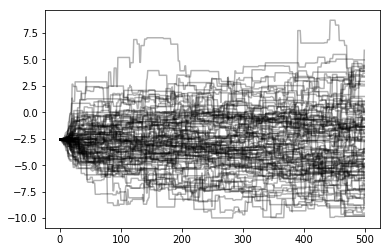

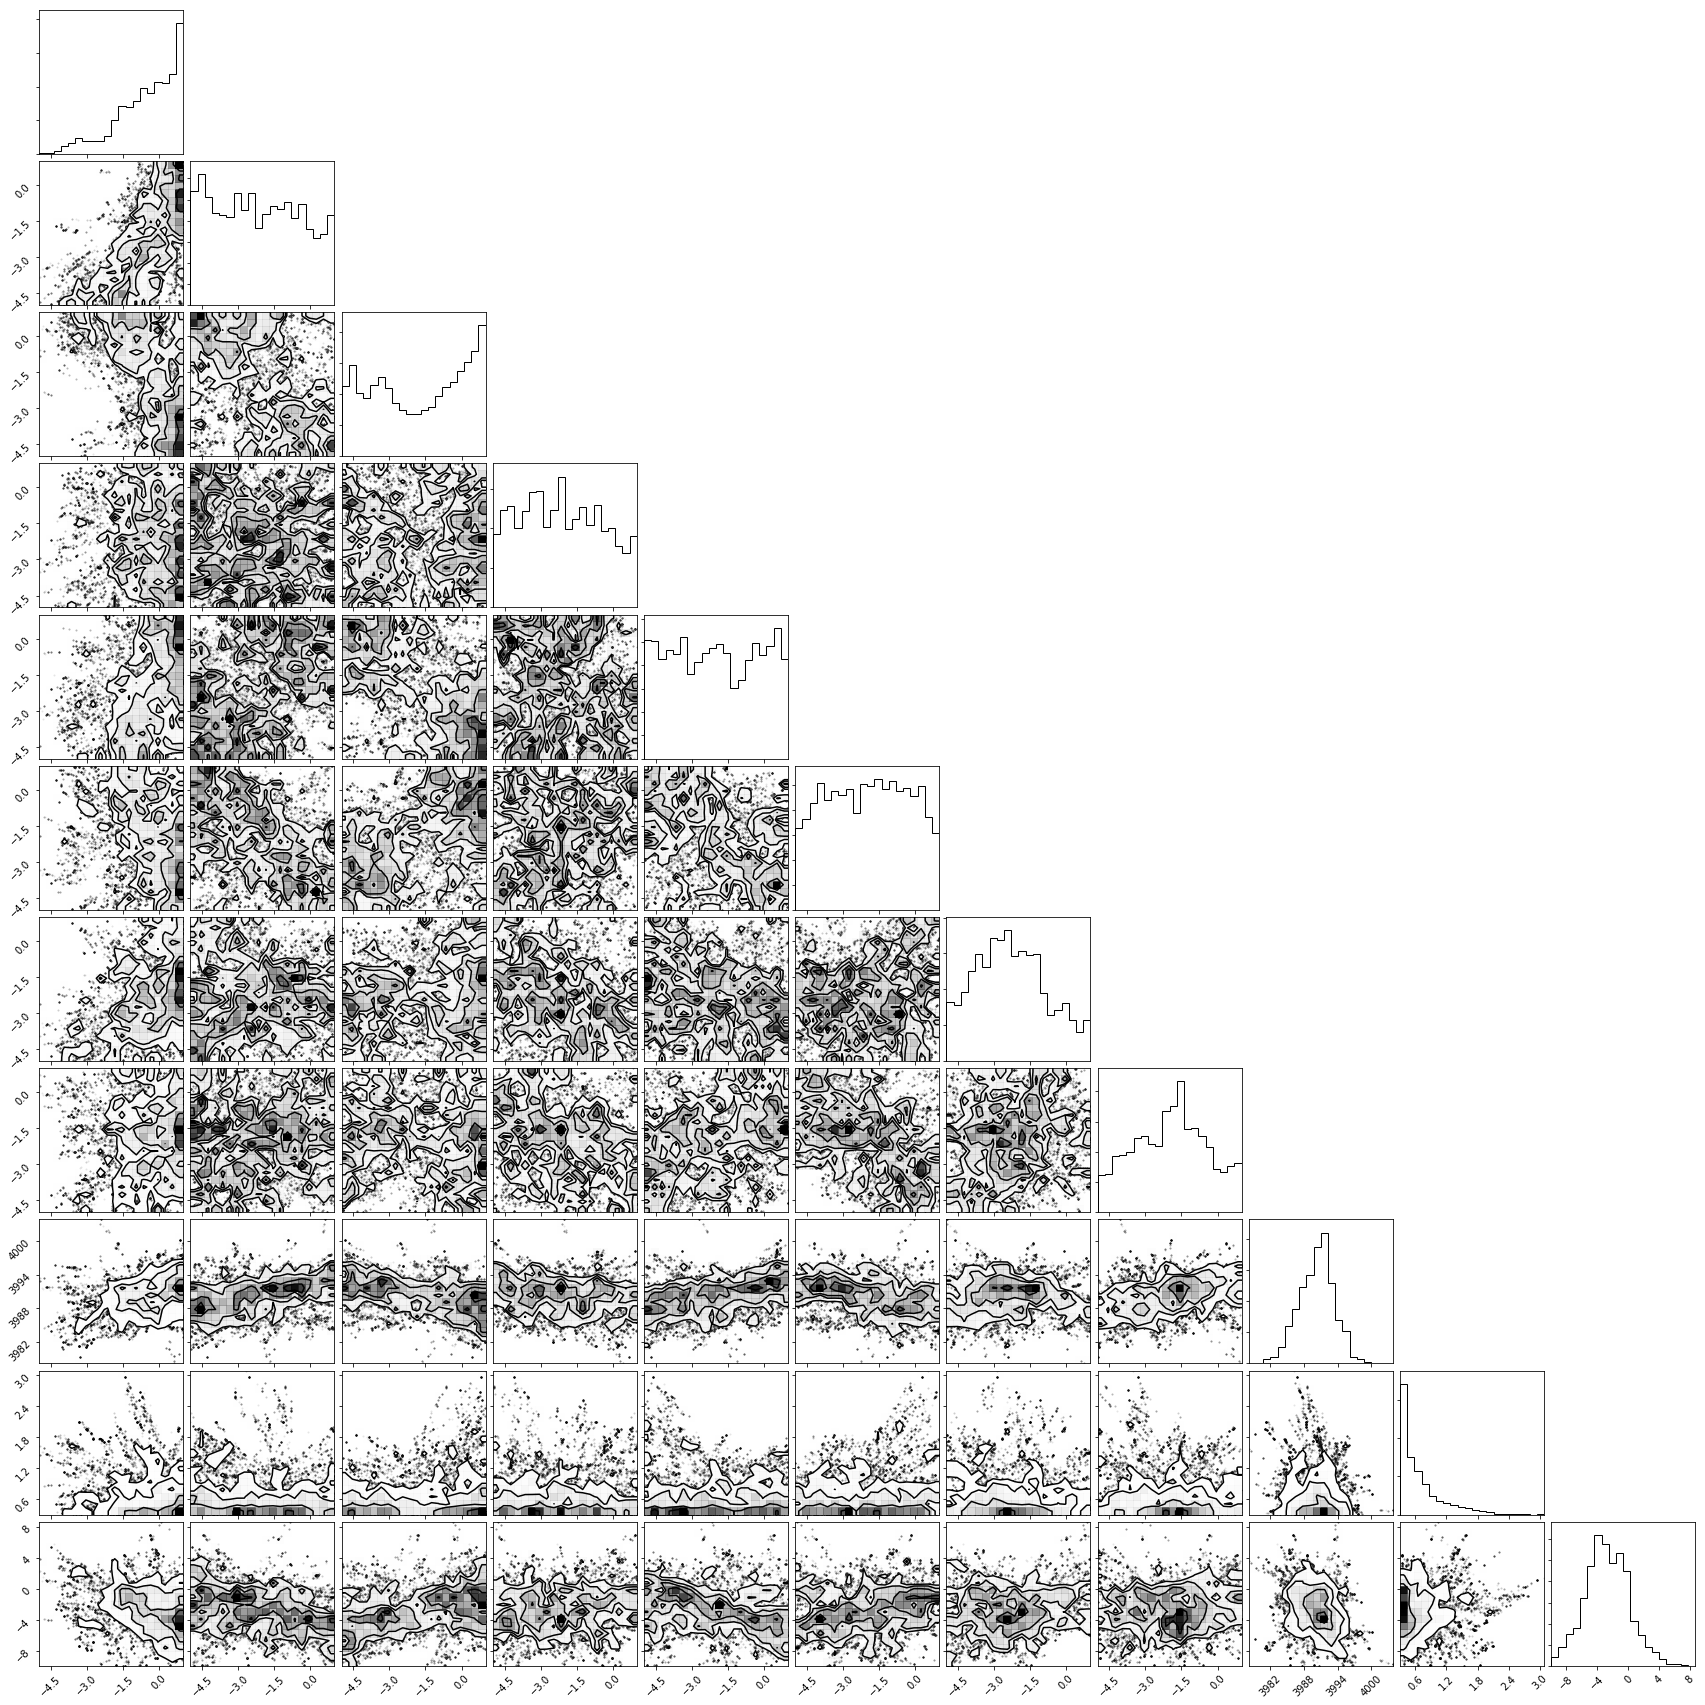

In [35]:
for i in range(ndim):
    plt.plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.3)
    plt.show()
    
samples = sampler.chain[:,50:,:].reshape((-1,ndim))
fig = corner.corner(samples)